### INFO284 Machine Learning exam, spring 2024
- by candidates 144 and 255
- delivered 30.4.2024
- word count: 2850

### Table of contents
1. [Introduction](#introduction)
2. [Preprocessing](#preprocessing)
    1. [Removing rows](#rows)
    2. [Removing Columns(part 1)](#column1)
    3. [Removing Columns(part 2)](#column2)
3. [Intermission: Clustering model: DBScan](#cluster)
    1. [Changing features](#change)
    2. [Pivoting dataframe](#pivot)
    3. [Narrowing our prediction window](#narrow)
    4. [Correlation Matrix](#correlation)
    5. [Scaling numerical features](#scaling)
    6. [One-hot encoding categorical features](#onehot)
4. [Modeling](#modeling)
    1. [Model 1: Random Forest Regressor](#model1)
    2. [Model 2: Xtreme Gradient Boosting](#model2)
    3. [Model 3: MLPRegressor](#model3)
    4. [Final model test](#final)
4. [Concluding comments](#conclusions)
5. [Referances](#ref)


#### Import and version control for relevant libraries.

We are working with the following versions:
- Python version: 3.12.1
- pandas version: 2.2.2
- matplotlib version: 3.8.4
- NumPy version: 1.26.4
- SciPy version: 1.13.0
- IPython version: 8.23.0
- scikit-learn version: 1.4.2
- seaborn version: 0.13.2

In [157]:
# Main imports
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import seaborn as sns
print("seaborn version: {}".format(sns.__version__))

# Support imports
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import DBSCAN
from sklearn.neural_network import MLPRegressor

Python version: 3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]
pandas version: 2.2.2
matplotlib version: 3.8.4
NumPy version: 1.26.4
SciPy version: 1.13.0
IPython version: 8.23.0
scikit-learn version: 1.4.2
seaborn version: 0.13.2


In [158]:
# Import of the dataset: File is encoded in UTF-8
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")

In [159]:
# This function shows how the datashape currently looks.
# We run it frequently to make clear what changes we are making, but if some steps are unclear just paste in status_dataframe(df).
def status_dataframe(dataframe):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    print(f"The dataset now has {dataframe.shape[1]} columns and {dataframe.shape[0]} rows")
    display(dataframe.head(5))
    dataframe.info()

status_dataframe(df)

The dataset now has 45 columns and 305434 rows


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,2018,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,OTM,"Flytetrål, otter",53.0,Flytetrål,KRI,Antarktisk krill,2513.0,KRI,Antarktisk krill,2513.0,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,HAD,Hyse,1027.0,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,COD,Torsk,1022.0,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,GHL,Blåkveite,2313.0,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,POK,Sei,1032.0,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305434 entries, 0 to 305433
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                305434 non-null  int64  
 1   Meldingstidspunkt         305434 non-null  object 
 2   Meldingsdato              305434 non-null  object 
 3   Meldingsklokkeslett       305434 non-null  object 
 4   Starttidspunkt            305434 non-null  object 
 5   Startdato                 305434 non-null  object 
 6   Startklokkeslett          305434 non-null  object 
 7   Startposisjon bredde      305434 non-null  object 
 8   Startposisjon lengde      305434 non-null  object 
 9   Hovedområde start (kode)  303433 non-null  float64
 10  Hovedområde start         301310 non-null  object 
 11  Lokasjon start (kode)     303433 non-null  float64
 12  Havdybde start            305434 non-null  int64  
 13  Stopptidspunkt            305434 non-null  o

### <a id="introduction">Introduction</a> 

This report is about applying machine learning models to data from Norwegian fisheries. We are using a dataset from 2018 supplied by our lecturer. The task we have chosen is a quantitative regression problem as we will be trying to predicate the catches of haddock, cod, and pollock(hyse, torsk and sei) as continuous values. To solve this we wil use three supervised machine learning models, including one deep learning model. In addition we will develop a clustering model you can use on the dataset. Our target value is a combination of the columns 'Art FAO,' which indicates the captured species, and 'Rundvekt,' which indicates the weight of the catch.

We will use a consistent seed to make the results from the various models more comparable, only randomizing it in later stages and when validating.

All the features and targets will be referred to by their Norwegian names.

In [160]:
seed = 32

### <a id="preprocessing"></a>Preprocessing

There has been a lot of data exploration and trial and error before we have arrived at the selection of features we are using. Not all of that will be visible, only what is necessary to argue for our removal and/or manipulation of features.

#### <a id="rows"></a>Removing rows

Rows:
- We remove all rows that are about other species than our target.
- We check the amount of NaN values in columns. Columns with high frequency of NaN values are processed later while columns with low NaN frequency have their rows removed.
- We remove all rows where the catch of our target species was 0.

In [161]:
# Keeping only catches of our target
df = df[df['Art FAO'].isin(['Torsk', 'Sei', 'Hyse'])]

In [162]:
# Checking the amount of NaN values
df.isnull().sum()

Melding ID                       0
Meldingstidspunkt                0
Meldingsdato                     0
Meldingsklokkeslett              0
Starttidspunkt                   0
Startdato                        0
Startklokkeslett                 0
Startposisjon bredde             0
Startposisjon lengde             0
Hovedområde start (kode)       387
Hovedområde start              912
Lokasjon start (kode)          387
Havdybde start                   0
Stopptidspunkt                   0
Stoppdato                        0
Stoppklokkeslett                 0
Varighet                         0
Fangstår                         0
Stopposisjon bredde              0
Stopposisjon lengde              0
Hovedområde stopp (kode)       373
Hovedområde stopp              912
Lokasjon stopp (kode)          373
Havdybde stopp                   0
Trekkavstand                     4
Redskap FAO (kode)               0
Redskap FAO                    165
Redskap FDIR (kode)            165
Redskap FDIR        

In [163]:
# Checking the amount of rows with low frequenc NaN values
exclude_columns = ['Bruttotonnasje 1969', 'Bruttotonnasje annen']
nan_count = df.drop(exclude_columns, axis=1).isnull().any(axis=1).sum()
print(f"There are {nan_count} rows with nan valeus.")

There are 1143 rows with nan valeus.


In [164]:
# Removing the NaN values
df.dropna(subset=[col for col in df.columns if col not in exclude_columns], inplace = True)
df.isnull().sum()

Melding ID                       0
Meldingstidspunkt                0
Meldingsdato                     0
Meldingsklokkeslett              0
Starttidspunkt                   0
Startdato                        0
Startklokkeslett                 0
Startposisjon bredde             0
Startposisjon lengde             0
Hovedområde start (kode)         0
Hovedområde start                0
Lokasjon start (kode)            0
Havdybde start                   0
Stopptidspunkt                   0
Stoppdato                        0
Stoppklokkeslett                 0
Varighet                         0
Fangstår                         0
Stopposisjon bredde              0
Stopposisjon lengde              0
Hovedområde stopp (kode)         0
Hovedområde stopp                0
Lokasjon stopp (kode)            0
Havdybde stopp                   0
Trekkavstand                     0
Redskap FAO (kode)               0
Redskap FAO                      0
Redskap FDIR (kode)              0
Redskap FDIR        

In [165]:
# Checking for 0 values in our target column
zero_values = (df['Rundvekt'] == 0).sum()
print(f"There are {zero_values} zeroes in the 'Rundvekt' column.")
df = df[df['Rundvekt'] != 0]
zero_values = (df['Rundvekt'] == 0).sum()
print(f"There are now {zero_values} zeroes in the 'Rundvekt' column.")

There are 28 zeroes in the 'Rundvekt' column.
There are now 0 zeroes in the 'Rundvekt' column.


#### <a id="column1"></a> Removing Columns(part 1):

- "Fangstår": The dataset is from 2018, but it contains some reports from 2017 as they were reported after New Year's Eve. We remove it because it only contains 2 unique values, where over 99% of them are just one of them.
- "Feature" and "Feature (kode)" are in nearly all instances the same information. We retain the categorical "Feature" because it is more human readable, removing the "Feature (kode)".
- "Hovedområde stopp (kode)" is the exception. By comparing it with "Hovedområde start", which has 1:1 relation with it's (kode) equivalent, we find that the highest frequency code in "Hovedområde stopp (kode)" for each entry in "Hovedområde stopp" overlaps 98 % of the time. From this we conclude it's a mistake in registration and remove it.
- Ship information (Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen, Bredde, Fartøylengde) represent nearly the same thing in different ways. We prove this by: (A) showing that with "Bruttotonnasje 1969" and "Bruttotonnasje annen" usually one column holds value while the other one is empty and vice versa. The columns are combined, priority given to "Bruttotonnasje 1969" due to that being a specific standard while "Bruttotonnasje annen" is not. Nan values are removed. (B) "Fartøylengde" is a more nuanced category of "Lengdegruppe". (C) "Fartøylengde", "Bredde" and "Bruttotonnasje" have a strong correlation. After proving this we choose to retain "Bruttotonnasje", which represents a ships max carrying capacity, as it seems the most relevant with regards to our target value being the weight of a catch.

In [166]:
# Testing how many unique values there are in "Fangstår"
value_counts = df['Fangstår'].value_counts()
print(value_counts)
df.drop(columns = ['Fangstår'], inplace= True)

Fangstår
2018    137069
2017        11
Name: count, dtype: int64


In [167]:
# Setting up a function to test the similarity between (mostly)categorical features
def test_similarity(dataframe, feature1, feature2):
    # Testing which values in one column matches to which value in the other column
    value_counts = dataframe.groupby([feature1, feature2]).size().unstack(fill_value=0)

    value_summary = {}

    for column in value_counts.columns:
        value_summary.setdefault(column, [])
        value_summary[column].extend(list(zip(
            value_counts.index[value_counts[column] != 0].tolist(),
            value_counts[value_counts[column] != 0][column].tolist()
        )))

    # Testing if the categorise have a 1:1 relation
    mismatched_values = []

    key_value_count = {key: len(value) for key, value in value_summary.items()}
    for key, value in key_value_count.items():
        if value > 1:
            mismatched_values.append(key)

    # Controlling for categorise that don't have any matches in the other column
    used_feature2_keys = [key for key in value_summary.keys()]

    feature2_keys = list(feature2.unique())

    unused_feature2_keys = []
    for x in feature2_keys:
        if x not in used_feature2_keys:
            unused_feature2_keys.append(x)
         
            
    used_feature1_keys = []

    for tupple_list in value_summary.values():
        for tupple in tupple_list:
            used_feature1_keys.append(tupple[0])

    feature1_keys = list(feature1.unique())

    unused_feature1_keys = []
    for x in feature1_keys:
        if x not in used_feature1_keys:
            unused_feature1_keys.append(x)

    # Printing our conclusions
    if len(unused_feature2_keys) > 0:
        print(f"Values in '{feature2.name}' which have no value in '{feature1.name}': {unused_feature2_keys}")
    if len(unused_feature1_keys) > 0:
        print(f"Values in '{feature1.name}' which have no value in '{feature2.name}': {unused_feature1_keys}")
    if len(mismatched_values) > 0:
        print(f"These values in '{feature2.name}' aren't the same in '{feature1.name}': {mismatched_values}.")
        return value_summary
    
    print(f"The values of '{feature2.name}' and '{feature1.name}' represent the same thing.") 
    # Returns a dictonary where the keys are values in feature2 and the values are tupples with the values of feature1 and a count of their frequency.
    # In case someone wants to inspect the results
    return value_summary

In [168]:
# Here follows a series of similairty tests
dictionary_summary = test_similarity(df, df["Redskap FAO"], df["Redskap FAO (kode)"])

The values of 'Redskap FAO (kode)' and 'Redskap FAO' represent the same thing.


In [169]:
dictionary_summary = test_similarity(df, df["Redskap FDIR"], df["Redskap FDIR (kode)"])

The values of 'Redskap FDIR (kode)' and 'Redskap FDIR' represent the same thing.


In [170]:
dictionary_summary = test_similarity(df, df["Hovedart FAO"], df["Hovedart FAO (kode)"])

The values of 'Hovedart FAO (kode)' and 'Hovedart FAO' represent the same thing.


In [171]:
dictionary_summary = test_similarity(df, df["Art FAO"], df["Art FAO (kode)"])

The values of 'Art FAO (kode)' and 'Art FAO' represent the same thing.


In [172]:
dictionary_summary = test_similarity(df, df["Art - FDIR (kode)"], df["Art - FDIR"])

The values of 'Art - FDIR' and 'Art - FDIR (kode)' represent the same thing.


In [173]:
dictionary_summary = test_similarity(df, df["Art - gruppe (kode)"], df["Art - gruppe"])

The values of 'Art - gruppe' and 'Art - gruppe (kode)' represent the same thing.


In [174]:
dictionary_summary = test_similarity(df, df["Lengdegruppe (kode)"], df["Lengdegruppe"])

The values of 'Lengdegruppe' and 'Lengdegruppe (kode)' represent the same thing.


In [175]:
dictionary_summary = test_similarity(df, df["Hovedområde start (kode)"], df["Hovedområde start"])

The values of 'Hovedområde start' and 'Hovedområde start (kode)' represent the same thing.


In [176]:
print('\n')

# Testing the exception
mismatched_dictionary = test_similarity(df, df["Hovedområde stopp (kode)"], df["Hovedområde stopp"])
print('\n')

# Setting up dictionaries for comparison
feature1_value_count = {}
for key, tuples in mismatched_dictionary.items():
    largest_count = max(tuples, key=lambda x: x[1])
    feature1_value_count[key] = largest_count

feature2_value_count = {}
for key, value in dictionary_summary.items():
    feature2_value_count[key] = value[0]

# Comparing the two features
same_code_count = 0
for key in feature1_value_count.keys():
    if key in feature2_value_count:
        feature1_code = feature1_value_count[key][0]
        feature2_code = feature2_value_count[key][0]
        if feature1_code == feature2_code:
            same_code_count += 1
        else:
            print(f"The area '{key}' has two different highest frequency codes: '{feature1_code}' and '{feature2_code}'.")

# calculating and printing results
percentage = (same_code_count / len(mismatched_dictionary)) * 100
print(f"'Hovedområde start' and 'Hovedområde stopp' have the same highest frequency code in {percentage} % of instances. ")



These values in 'Hovedområde stopp' aren't the same in 'Hovedområde stopp (kode)': ['Admiralityfeltet', 'Bjørnøya', 'Britvinfeltet', 'Eigersundbanken', 'Færøybanken', 'Gåsebanken', 'Helgelandsbanken', 'Hopen', 'Kaninbanken', 'Murmanskkysten', 'Nordkappbanken', 'Nordøstområdet', 'Rockall', 'Røstbanken til Malangsgrunnen', 'Sentralbanken', 'Sentrale Nordsjø', 'Shetland', 'Skagerrak', 'Skolpenbanken', 'Storbanken', 'Storegga-Frøyabanken', 'Storfjord/Hinlopenstredet', 'Sørlige Norskehav', 'Sørvest av Spitsbergen', 'Thor Iversens Bank', 'Vest av Færøyene', 'Vest av Skottland (Hebridene)', 'Vest av Tromsøflaket', 'Vest-Finnmark', 'Vest-Spitsbergen', 'Vestfjorden (Lofoten)', 'Vikingbanken', 'Øst av Færøyene', 'Øst-Finnmark', 'Østlige Norskehav'].


The area 'Sørvest av Spitsbergen' has two different highest frequency codes: '20.0' and '27.0'.
'Hovedområde start' and 'Hovedområde stopp' have the same highest frequency code in 97.72727272727273 % of instances. 


In [177]:
df.drop(columns=["Hovedområde start (kode)", "Hovedområde stopp (kode)", "Redskap FAO (kode)", "Redskap FDIR (kode)", "Hovedart FAO (kode)",
                 "Art FAO (kode)","Art - FDIR (kode)", "Art - gruppe (kode)", "Lengdegruppe (kode)"], inplace=True)

In [178]:
# Comparing NaN value distribution
b_nan = df['Bruttotonnasje 1969'].notnull() & df['Bruttotonnasje annen'].isnull()
a_nan = df['Bruttotonnasje annen'].notnull() & df['Bruttotonnasje 1969'].isnull()
both = df['Bruttotonnasje annen'].notnull() & df['Bruttotonnasje 1969'].notnull()
both_nan = df['Bruttotonnasje 1969'].isnull() & df['Bruttotonnasje annen'].isnull()

print(f"""Rows where only 'Bruttotonnasje 1969' has values: {b_nan.sum()}
Rows where only 'Bruttotonnasje annen' has values: {a_nan.sum()}
Rows where both columns have values: {both.sum()}
Rows where both columns have nan values: {both_nan.sum()}""")

df['Bruttotonnasje'] = df['Bruttotonnasje 1969'].combine_first(df['Bruttotonnasje annen'])

Rows where only 'Bruttotonnasje 1969' has values: 101453
Rows where only 'Bruttotonnasje annen' has values: 32427
Rows where both columns have values: 2479
Rows where both columns have nan values: 721


In [179]:
# Changing column type
df['Fartøylengde'] = df['Fartøylengde'].str.replace(',', '.').astype(float)
df['Bredde'] = df['Bredde'].str.replace(',', '.').astype(float)

In [180]:
# Showing that 'Fartøylengde' numbers stay within the length categorise set by 'Lengdegruppe'
min_max_values = df.groupby('Lengdegruppe')['Fartøylengde'].agg(['min', 'max'])
print(min_max_values)

                min    max
Lengdegruppe              
15-20,99 m    15.01  20.99
21-27,99 m    21.07  27.99
28 m og over  28.10  81.20


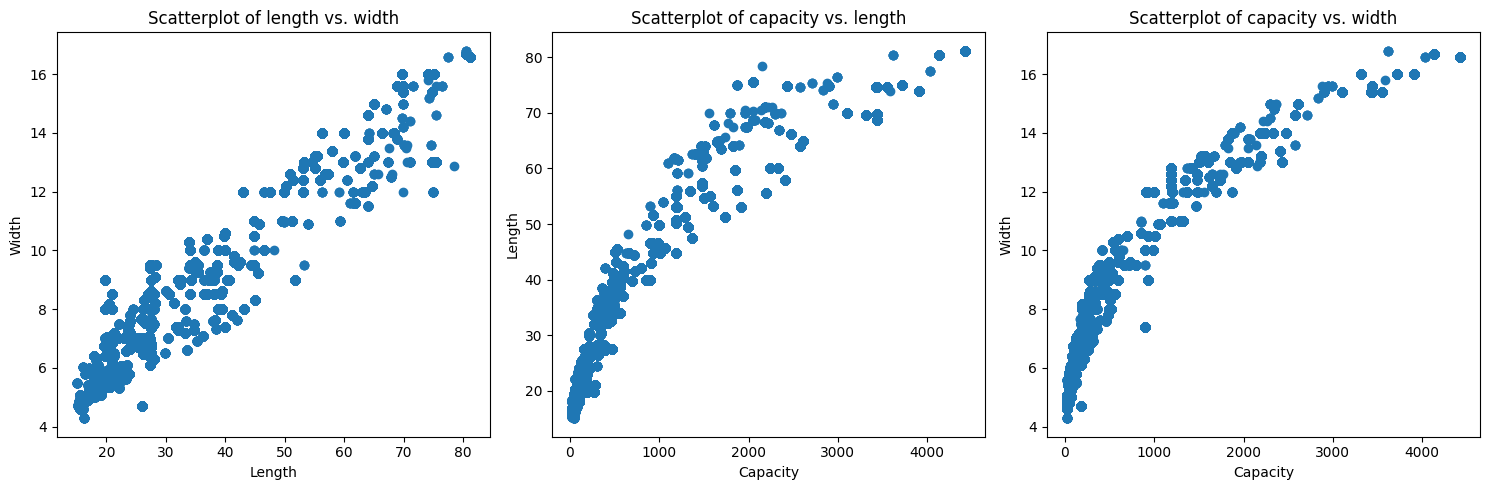

Correlation coefficient between Fartøylengde and Bredde: 0.9523645617206321
Correlation coefficient between Fartøylengde and Bruttotonnasje: 0.9358818501323718
Correlation coefficient between Bruttotonnasje and Bredde: 0.9304127294950256


In [181]:
# Setting up scatterplots to show similiary between "Fartøylengde", "Bruttotonnasje" and "Bredde"
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(df['Fartøylengde'], df['Bredde'])
axs[0].set_xlabel('Length')
axs[0].set_ylabel('Width')
axs[0].set_title('Scatterplot of length vs. width')

axs[1].scatter(df['Bruttotonnasje'], df['Fartøylengde'])
axs[1].set_xlabel('Capacity')
axs[1].set_ylabel('Length')
axs[1].set_title('Scatterplot of capacity vs. length')

axs[2].scatter(df['Bruttotonnasje'], df['Bredde'])
axs[2].set_xlabel('Capacity')
axs[2].set_ylabel('Width')
axs[2].set_title('Scatterplot of capacity vs. width')

plt.tight_layout()
plt.show()

# Showing correlation between the three features
correlation = df['Fartøylengde'].corr(df['Bredde'])
print(f"Correlation coefficient between {df['Fartøylengde'].name} and {df['Bredde'].name}:", correlation)
correlation = df['Fartøylengde'].corr(df['Bruttotonnasje'])
print(f"Correlation coefficient between {df['Fartøylengde'].name} and {df['Bruttotonnasje'].name}:", correlation)
correlation = df['Bruttotonnasje'].corr(df['Bredde'])
print(f"Correlation coefficient between {df['Bruttotonnasje'].name} and {df['Bredde'].name}:", correlation)

In [182]:
df.drop(columns=['Bruttotonnasje annen', "Bruttotonnasje 1969", "Lengdegruppe", "Bredde", "Fartøylengde"], inplace=True)
df = df.dropna()
status_dataframe(df)

The dataset now has 31 columns and 136359 rows


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO,Redskap FDIR,Hovedart FAO,Hovedart - FDIR (kode),Art FAO,Art - FDIR,Art - gruppe,Rundvekt,Bruttotonnasje
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Hyse,Hyse,Hyse,9594.0,1476.0
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Torsk,Torsk,Torsk,8510.0,1476.0
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Sei,Sei,Sei,134.0,1476.0
5,1497178,01.01.2018,01.01.2018,00:00,31.12.2017 05:48,31.12.2017,05:48,"74,91","15,868",Bjørnøya,7.0,-403,31.12.2017 10:15,31.12.2017,10:15,267,"74,901","16,248",Bjørnøya,7.0,-277,11096.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Hyse,Hyse,Hyse,9118.0,1476.0
6,1497178,01.01.2018,01.01.2018,00:00,31.12.2017 05:48,31.12.2017,05:48,"74,91","15,868",Bjørnøya,7.0,-403,31.12.2017 10:15,31.12.2017,10:15,267,"74,901","16,248",Bjørnøya,7.0,-277,11096.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Torsk,Torsk,Torsk,6651.0,1476.0


<class 'pandas.core.frame.DataFrame'>
Index: 136359 entries, 1 to 305428
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Melding ID              136359 non-null  int64  
 1   Meldingstidspunkt       136359 non-null  object 
 2   Meldingsdato            136359 non-null  object 
 3   Meldingsklokkeslett     136359 non-null  object 
 4   Starttidspunkt          136359 non-null  object 
 5   Startdato               136359 non-null  object 
 6   Startklokkeslett        136359 non-null  object 
 7   Startposisjon bredde    136359 non-null  object 
 8   Startposisjon lengde    136359 non-null  object 
 9   Hovedområde start       136359 non-null  object 
 10  Lokasjon start (kode)   136359 non-null  float64
 11  Havdybde start          136359 non-null  int64  
 12  Stopptidspunkt          136359 non-null  object 
 13  Stoppdato               136359 non-null  object 
 14  Stoppklokkeslett        1

#### <a id="column2"></a> Removing Columns(part 2):
- "Hovedområde start" , "Lokasjon start (kode)", "Hovedområde stopp", "Lokasjon stopp (kode)": are described in (ref 2) as "Dette er en beregnet verdi fra system med bakgrunn i posisjoner som fisker oppgir i innrapporteringen i fangstmeldingen." Which means that the columns representing coordinates represent the same information, but as more nuanced continuous values. These columns will be dropped.
- "Hovedart FAO" and "Hovedart - FDIR (kode)": are described in (ref 1) as "Art som det er fisket mest av i følge innrapporteringen." Which means it's a feature derived from our target, which means it risks data leakage, in addition to being information generated after the event we are trying to predicate.
- "Melding ID", "Meldingstidspunkt", "Meldingsdato", "Meldingsklokkeslett": Represents information which is generated after the event and with no relation to the event itself. "Melding ID" will be kept to be used as an identifier for rows representing the same fishing session, after these rows are collapsed together it will be removed.
- "Redskap FAO", "Redskap FDIR", "Art FAO", "Art - FDIR", "Art - gruppe": The abbreviations stand for FAO = Food and Agriculture Organization of the United Nations and FDIR = Fiskeridirektoratet, while "gruppe" is in (ref 2) described as "nokre er slått saman og vises som gruppe. Bakgrunnen for at vi har valt å innføre dette nivået er at nokre av artane i Fiskeridirektoratets kodeliste vert brukt ulikt av dei ulike fiskesalslaga." This means that they are essentially the same information, just categorised differently. For our purposes we choose to keep the most nuanced categorical values: Redskap FAO and Art FAO.
- "Starttidspunkt" and "Stopptidspunkt": is a feature that consists of the features of date and time for the start and end of the fishing session. As we will be using the date and time features these are redundant and will be removed.

In [183]:
df.drop(columns=["Hovedområde start", "Lokasjon start (kode)", "Hovedområde stopp", "Lokasjon stopp (kode)", "Hovedart FAO",
                 "Hovedart - FDIR (kode)", "Meldingstidspunkt", "Meldingsdato", "Meldingsklokkeslett"], inplace=True)

In [184]:
# Here follows a series of similairty tests
utskrift = test_similarity(df, df["Redskap FDIR"], df["Redskap FAO"])


The values of 'Redskap FAO' and 'Redskap FDIR' represent the same thing.


In [185]:
utskrift = test_similarity(df, df["Art - FDIR"], df["Art FAO"])

The values of 'Art FAO' and 'Art - FDIR' represent the same thing.


In [186]:
utskrift = test_similarity(df, df["Art - gruppe"], df["Art FAO"])

The values of 'Art FAO' and 'Art - gruppe' represent the same thing.


In [187]:
df.drop(columns= ["Redskap FDIR", "Art - FDIR", "Art - gruppe"], inplace = True)

In [188]:
# Extracting dates and times so that they can be tested for similarity
df['Sta_dato'] = df['Starttidspunkt'].str[:10]
df['Sta_tid'] = df['Starttidspunkt'].str[12:]
df['Sto_dato'] = df['Stopptidspunkt'].str[:10]
df['Sto_tid'] = df['Stopptidspunkt'].str[12:]

In [189]:
utskrift = test_similarity(df, df["Sta_dato"], df["Startdato"])

The values of 'Startdato' and 'Sta_dato' represent the same thing.


In [190]:
utskrift = test_similarity(df, df["Sta_tid"], df["Startklokkeslett"])

The values of 'Startklokkeslett' and 'Sta_tid' represent the same thing.


In [191]:
utskrift = test_similarity(df, df["Sto_dato"], df["Stoppdato"])

The values of 'Stoppdato' and 'Sto_dato' represent the same thing.


In [192]:
utskrift = test_similarity(df, df["Sto_tid"], df["Stoppklokkeslett"])

The values of 'Stoppklokkeslett' and 'Sto_tid' represent the same thing.


In [193]:
df.drop(columns = ["Sto_tid", "Sto_dato", "Sta_tid", "Sta_dato", "Starttidspunkt", "Stopptidspunkt"], inplace = True)

In [194]:
status_dataframe(df)

The dataset now has 17 columns and 136359 rows


,Melding ID,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Havdybde start,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FAO,Art FAO,Rundvekt,Bruttotonnasje
1,1497178,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,9594.0,1476.0
2,1497178,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Torsk,8510.0,1476.0
4,1497178,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Sei,134.0,1476.0
5,1497178,31.12.2017,05:48,"74,91","15,868",-403,31.12.2017,10:15,267,"74,901","16,248",-277,11096.0,"Bunntrål, otter",Hyse,9118.0,1476.0
6,1497178,31.12.2017,05:48,"74,91","15,868",-403,31.12.2017,10:15,267,"74,901","16,248",-277,11096.0,"Bunntrål, otter",Torsk,6651.0,1476.0


<class 'pandas.core.frame.DataFrame'>
Index: 136359 entries, 1 to 305428
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Melding ID            136359 non-null  int64  
 1   Startdato             136359 non-null  object 
 2   Startklokkeslett      136359 non-null  object 
 3   Startposisjon bredde  136359 non-null  object 
 4   Startposisjon lengde  136359 non-null  object 
 5   Havdybde start        136359 non-null  int64  
 6   Stoppdato             136359 non-null  object 
 7   Stoppklokkeslett      136359 non-null  object 
 8   Varighet              136359 non-null  int64  
 9   Stopposisjon bredde   136359 non-null  object 
 10  Stopposisjon lengde   136359 non-null  object 
 11  Havdybde stopp        136359 non-null  int64  
 12  Trekkavstand          136359 non-null  float64
 13  Redskap FAO           136359 non-null  object 
 14  Art FAO               136359 non-null  object 
 15  Rundv

### <a id="cluster"></a> Intermission: Clustering model: DBScan

For our clustering model we have set up a mulitidimensional DBScan model(ref?) that outputs a box plot visualising the clusters. We are not using it in the context of our other models because by the time we had made it it didn't offer us any new insight into our data. What made us interested in using it is its ability to find clusters that might be hidden and defining noise. A challenge once you go beyond the second and third dimension is how to visualize it in a way that is easy to understand. In this instance we choose to use boxplots, but that doesn't mean we immediately understood the shape of the clusters. Understanding the visualisations well is its own kind of practice.

In [195]:
df['Startposisjon bredde'] = df['Startposisjon bredde'].str.replace(',', '.').astype(float)
df['Startposisjon lengde'] = df['Startposisjon lengde'].str.replace(',', '.').astype(float)
df['Stopposisjon bredde'] = df['Stopposisjon bredde'].str.replace(',', '.').astype(float)
df['Stopposisjon lengde'] = df['Stopposisjon lengde'].str.replace(',', '.').astype(float)

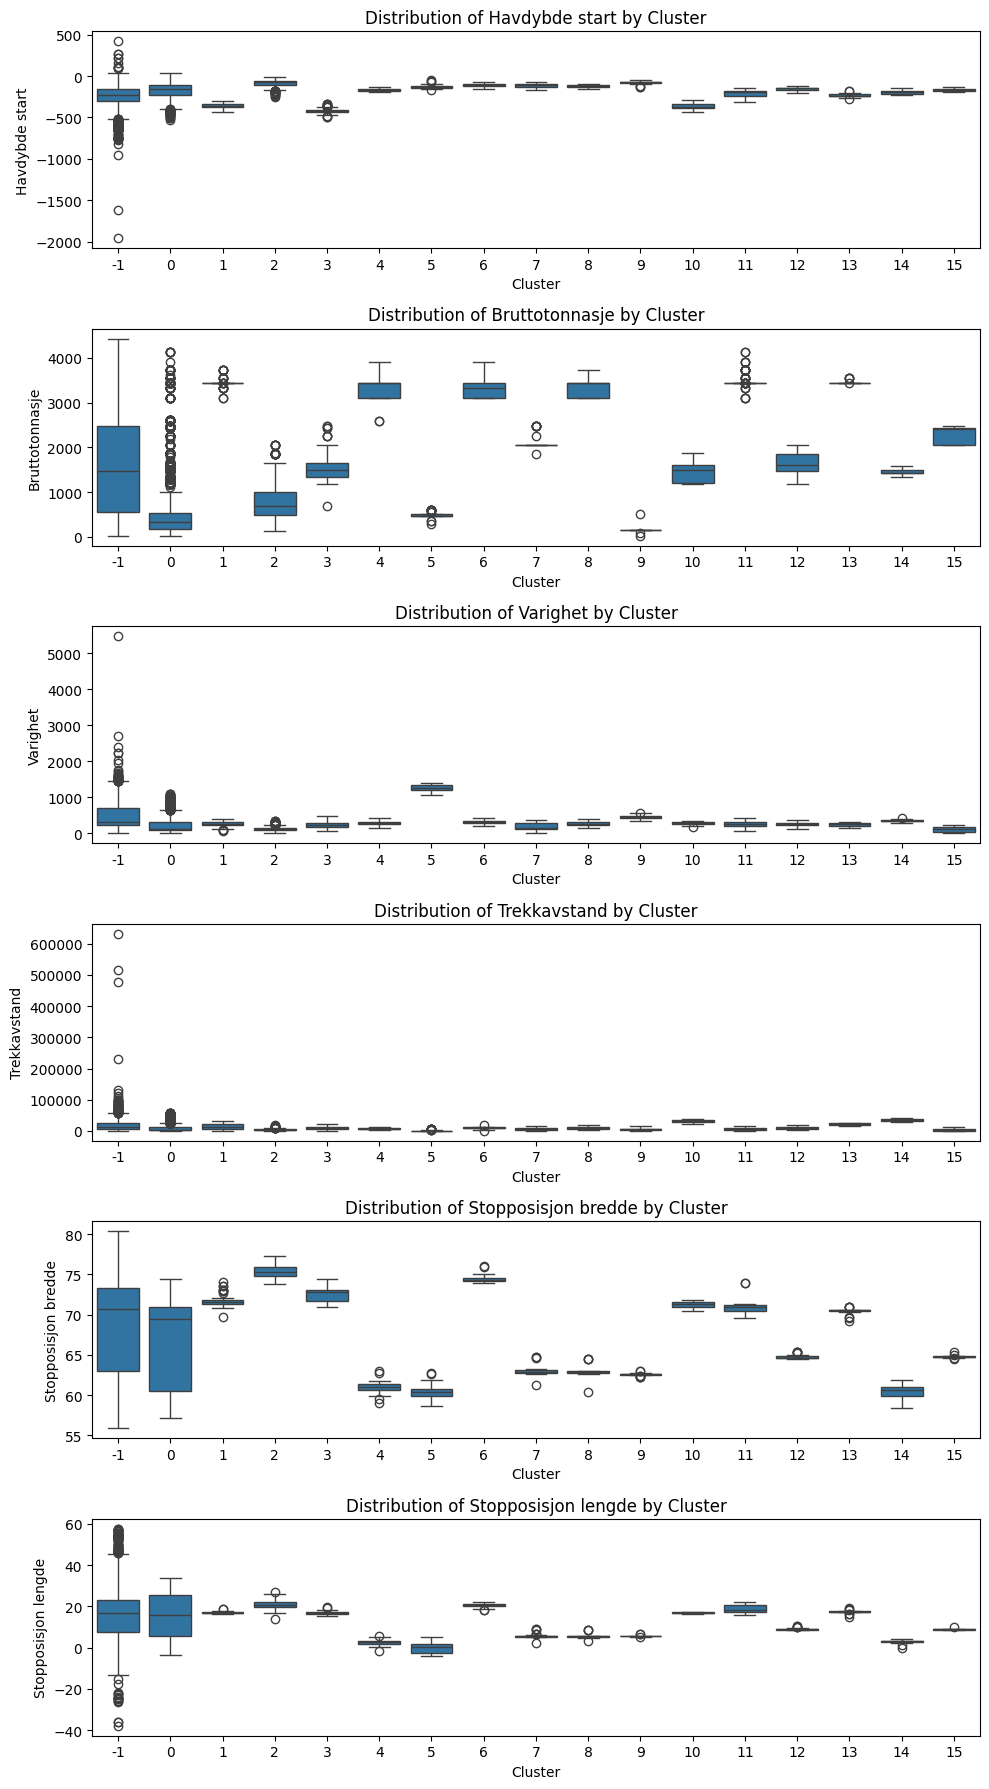

Havdybde start                                                         \
                 count        mean         std     min     25%    50%     75%   
Cluster                                                                         
-1              3724.0 -236.662191  126.552028 -1959.0 -299.00 -224.0 -153.00   
 0              5301.0 -168.103754   77.582084  -531.0 -224.00 -157.0 -109.00   
 1                74.0 -362.743243   31.606771  -433.0 -379.00 -356.0 -343.00   
 2               332.0  -85.623494   44.323104  -249.0 -103.75  -68.0  -56.00   
 3               127.0 -422.070866   30.818254  -490.0 -440.00 -426.0 -412.50   
 4                32.0 -163.593750   18.211764  -192.0 -179.00 -166.0 -152.75   
 5                54.0 -127.203704   21.485739  -166.0 -139.75 -130.0 -122.50   
 6                27.0 -109.444444   20.287043  -152.0 -119.50 -112.0  -94.00   
 7                41.0 -115.146341   21.836393  -167.0 -130.00 -113.0  -98.00   
 8                43.0 -121.651163   16.036987  -162.0 -131.00 -119.0 -109.00   
 9                23.0  -82.739130   21.867821  -136.0  -90.00  -74.0  -71.00   
 10               40.0 -362.150000   36.593085  -436.0 -384.75 -368.5 -337.00   
 11               87.0 -209.942529   38.231351  -309.0 -242.50 -196.0 -183.00   
 12               36.0 -153.083333   18.218319  -203.0 -167.50 -148.0 -140.00   
 13               20.0 -233.700000   25.288025  -281.0 -245.00 -237.0 -222.25   
 14               18.0 -195.500000   26.973298  -230.0 -219.75 -192.5 -179.25   
 15               21.0 -167.857143   20.669508  -199.0 -182.00 -174.0 -157.00   

               Bruttotonnasje                                            \
           max          count         mean          std     min     25%   
Cluster                                                                   
-1       420.0         3724.0  1676.448711  1238.987387    21.0   562.0   
 0        40.0         5301.0   571.164497   671.545161    22.0   182.0   
 1      -301.0           74.0  3453.337838   108.287957  3104.0  3439.0   
 2        -9.0          332.0   752.316265   426.509290   137.0   498.0   
 3      -337.0          127.0  1538.771654   318.225242   691.0  1332.0   
 4      -127.0           32.0  3355.906250   312.610792  2580.0  3104.0   
 5       -52.0           54.0   493.629630    60.827407   287.0   469.0   
 6       -74.0           27.0  3346.629630   233.233978  3104.0  3104.0   
 7       -76.0           41.0  2114.512195   157.279230  1853.0  2053.0   
 8       -97.0           43.0  3336.720930   221.187846  3104.0  3104.0   
 9       -53.0           23.0   153.347826    80.367117    24.0   146.0   
 10     -291.0           40.0  1479.125000   218.617238  1190.0  1199.0   
 11     -141.0           87.0  3493.781609   172.096811  3104.0  3439.0   
 12     -121.0           36.0  1629.944444   240.557322  1190.0  1476.0   
 13     -181.0           20.0  3462.250000    44.599829  3430.0  3439.0   
 14     -141.0           18.0  1455.055556    58.221153  1345.0  1427.0   
 15     -129.0           21.0  2287.761905   179.825166  2053.0  2053.0   

                                 Varighet                                   \
            50%      75%     max    count         mean         std     min   
Cluster                                                                      
-1       1476.0  2475.00  4427.0   3724.0   489.729323  410.512436     0.0   
 0        326.0   536.00  4129.0   5301.0   213.787965  200.846920     0.0   
 1       3443.0  3443.00  3723.0     74.0   253.918919   71.960369    68.0   
 2        691.0  1003.00  2053.0    332.0   119.608434   69.158496     0.0   
 3       1498.0  1648.00  2475.0    127.0   238.645669   86.476855    66.0   
 4       3439.0  3443.00  3909.0     32.0   284.562500   62.429283   155.0   
 5        469.0   499.00   593.0     54.0  1253.333333   83.560847  1073.0   
 6       3317.0  3442.00  3909.0     27.0   322.148148   55.781651   212.0   
 7       2053.0  2053.00  24

In [197]:
# A function that runs a x dimensional DBScan model, outputs a boxplot and returns the clustering results
def cluster_and_visualize_model(df, features, sample_size=10000, epsilon=0.5, min_samples=20, seed=None):
    
    # We are taking the data to 10000 samples to make it run fast
    sampled_df = df.sample(n=sample_size, random_state=seed)
    sampled_df = sampled_df[features]
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(sampled_df)  

    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    clusters = dbscan.fit_predict(scaled_data)

    sampled_df['Cluster'] = clusters
    cluster_stats = sampled_df.groupby('Cluster').describe()
    
    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(10, 3 * len(features)))
    for i, column in enumerate(features):
        sns.boxplot(x='Cluster', y=column, data=sampled_df, ax=axes[i])
        axes[i].set_title(f'Distribution of {column} by Cluster')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(column)
    plt.tight_layout()
    plt.show()
    return cluster_stats

# Example usage:
features = ["Havdybde start", "Bruttotonnasje", "Varighet", "Trekkavstand", "Stopposisjon bredde", "Stopposisjon lengde"]
cluster_and_visualize_model(df, features)


#### <a id="change"></a> Changing features
- Coordinates and time: These are circular and need to be encoded as that so that they are not seen as continuous values.
- Sea Depth: A few of the sea depth notations are positive, which is nonsensical. As mentioned in the lecture on fisheries these are probably inputs where someone forgot to write a minus. But probably doesn't mean certain and they are few so we remove these rows.
- "Varighet": According to our lecturer anything above 400 minutes is in the high range og how long a fishing session takes. After looking at the distribution we choose to consider anything above 400 as unnaturally long sessions or multiple sessions reported as one. Either way we remove these outliers to get a more even distribution for our model.
- "Trekkavstand": While we don't know the typical length a ship will travel during a fishing session we will set the cut-off at the 75 percentile to remove outliers and get a more even distribution.

In [120]:
# A function for circular encoding of features
def circular_encode(data, max_val):
    sin_encoded = np.sin(2 * np.pi * data / max_val)
    cos_encoded = np.cos(2 * np.pi * data / max_val)
    return sin_encoded, cos_encoded

In [121]:
# Circular encoding of coordinates
df['Startposisjon bredde'] = df['Startposisjon bredde'].str.replace(',', '.').astype(float)
df['Startposisjon lengde'] = df['Startposisjon lengde'].str.replace(',', '.').astype(float)
df['Stopposisjon bredde'] = df['Stopposisjon bredde'].str.replace(',', '.').astype(float)
df['Stopposisjon lengde'] = df['Stopposisjon lengde'].str.replace(',', '.').astype(float)

df['Startposisjon bredde_sin'], df['Startposisjon bredde_cos'] = circular_encode(df['Startposisjon bredde'], 180)
df['Startposisjon lengde_sin'], df['Startposisjon lengde_cos'] = circular_encode(df['Startposisjon lengde'], 360)
df['Stopposisjon bredde_sin'], df['Stopposisjon bredde_cos'] = circular_encode(df['Stopposisjon bredde'], 180)
df['Stopposisjon lengde_sin'], df['Stopposisjon lengde_cos'] = circular_encode(df['Stopposisjon lengde'], 360)

In [122]:
# Circular encoding of time of day
df["Starttime"] = pd.to_datetime(df["Startklokkeslett"], format='%H:%M').dt.hour
df["Stopptime"] = pd.to_datetime(df["Stoppklokkeslett"], format='%H:%M').dt.hour
df["Startminutt"] = pd.to_datetime(df["Startklokkeslett"], format='%H:%M').dt.minute
df["Stoppminutt"] = pd.to_datetime(df["Stoppklokkeslett"], format='%H:%M').dt.minute

df['Startklokke_sin'], df['Startklokke_cos'] = circular_encode(df['Starttime'] * 60 + df['Startminutt'], max_val=24*60)
df['Stoppklokke_sin'], df['Stoppklokke_cos'] = circular_encode(df['Stopptime'] * 60 + df['Stoppminutt'], max_val=24*60)

In [123]:
# Circular encoding of day of the year
df['Startdag'] = (pd.to_datetime(df['Startdato'], format='%d.%m.%Y') - pd.to_datetime(df['Startdato'].str[-4:], format='%Y')).dt.days+1
df['Stoppdag'] = (pd.to_datetime(df['Stoppdato'], format='%d.%m.%Y') - pd.to_datetime(df['Stoppdato'].str[-4:], format='%Y')).dt.days+1

df['Startdag_sin'], df['Startdag_cos'] = circular_encode(df['Startdag'], max_val=365)
df['Stoppdag_sin'], df['Stoppdag_cos'] = circular_encode(df['Stoppdag'], max_val=365)

In [124]:
df.drop(columns=["Startdag", "Stoppdag", "Startdato", "Stoppdato", "Starttime", "Stopptime", "Startminutt", "Stoppminutt",
                 "Startklokkeslett", "Stoppklokkeslett", "Startposisjon bredde", "Startposisjon lengde", 'Stopposisjon bredde',
                 'Stopposisjon lengde'], inplace=True)

status_dataframe(df)

The dataset now has 25 columns and 136359 rows


,Melding ID,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Redskap FAO,Art FAO,Rundvekt,Bruttotonnasje,Startposisjon bredde_sin,Startposisjon bredde_cos,Startposisjon lengde_sin,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Startklokke_sin,Startklokke_cos,Stoppklokke_sin,Stoppklokke_cos,Startdag_sin,Startdag_cos,Stoppdag_sin,Stoppdag_cos
1,1497178,-335,295,-334,3970.0,"Bunntrål, otter",Hyse,9594.0,1476.0,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411,-0.16935,0.985556,0.898794,0.438371,-1.721336e-02,0.999852,6.432491e-16,1.0
2,1497178,-335,295,-334,3970.0,"Bunntrål, otter",Torsk,8510.0,1476.0,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411,-0.16935,0.985556,0.898794,0.438371,-1.721336e-02,0.999852,6.432491e-16,1.0
4,1497178,-335,295,-334,3970.0,"Bunntrål, otter",Sei,134.0,1476.0,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411,-0.16935,0.985556,0.898794,0.438371,-1.721336e-02,0.999852,6.432491e-16,1.0
5,1497178,-403,267,-277,11096.0,"Bunntrål, otter",Hyse,9118.0,1476.0,0.502718,-0.864450,0.273422,0.961894,0.502990,-0.864292,0.279796,0.960060,0.99863,0.052336,0.442289,-0.896873,6.432491e-16,1.000000,6.432491e-16,1.0
6,1497178,-403,267,-277,11096.0,"Bunntrål, otter",Torsk,6651.0,1476.0,0.502718,-0.864450,0.273422,0.961894,0.502990,-0.864292,0.279796,0.960060,0.99863,0.052336,0.442289,-0.896873,6.432491e-16,1.000000,6.432491e-16,1.0


<class 'pandas.core.frame.DataFrame'>
Index: 136359 entries, 1 to 305428
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                136359 non-null  int64  
 1   Havdybde start            136359 non-null  int64  
 2   Varighet                  136359 non-null  int64  
 3   Havdybde stopp            136359 non-null  int64  
 4   Trekkavstand              136359 non-null  float64
 5   Redskap FAO               136359 non-null  object 
 6   Art FAO                   136359 non-null  object 
 7   Rundvekt                  136359 non-null  float64
 8   Bruttotonnasje            136359 non-null  float64
 9   Startposisjon bredde_sin  136359 non-null  float64
 10  Startposisjon bredde_cos  136359 non-null  float64
 11  Startposisjon lengde_sin  136359 non-null  float64
 12  Startposisjon lengde_cos  136359 non-null  float64
 13  Stopposisjon bredde_sin   136359 non-null  float6

In [125]:
# Counting number of sea depth instances above 0
instances_above_zero = (df['Havdybde stopp'] > 0).sum()
print("Number of instances above 0 in 'Havdybde stopp':", instances_above_zero)
instances_above_zero = (df['Havdybde start'] > 0).sum()
print("Number of instances above 0 in 'Havdybde start':", instances_above_zero)
instances_above_zero = ((df['Havdybde start'] > 0) & (df['Havdybde stopp'] > 0)).sum()
print("Number of rows where both 'Havdybde stopp' and  'Havdybde start' are above 0:", instances_above_zero)

Number of instances above 0 in 'Havdybde stopp': 481
Number of instances above 0 in 'Havdybde start': 506
Number of rows where both 'Havdybde stopp' and  'Havdybde start' are above 0: 296


In [126]:
filtered_rows = df[(df['Havdybde stopp'] > 0) | (df['Havdybde start'] > 0)]
df.drop(filtered_rows.index, inplace = True)

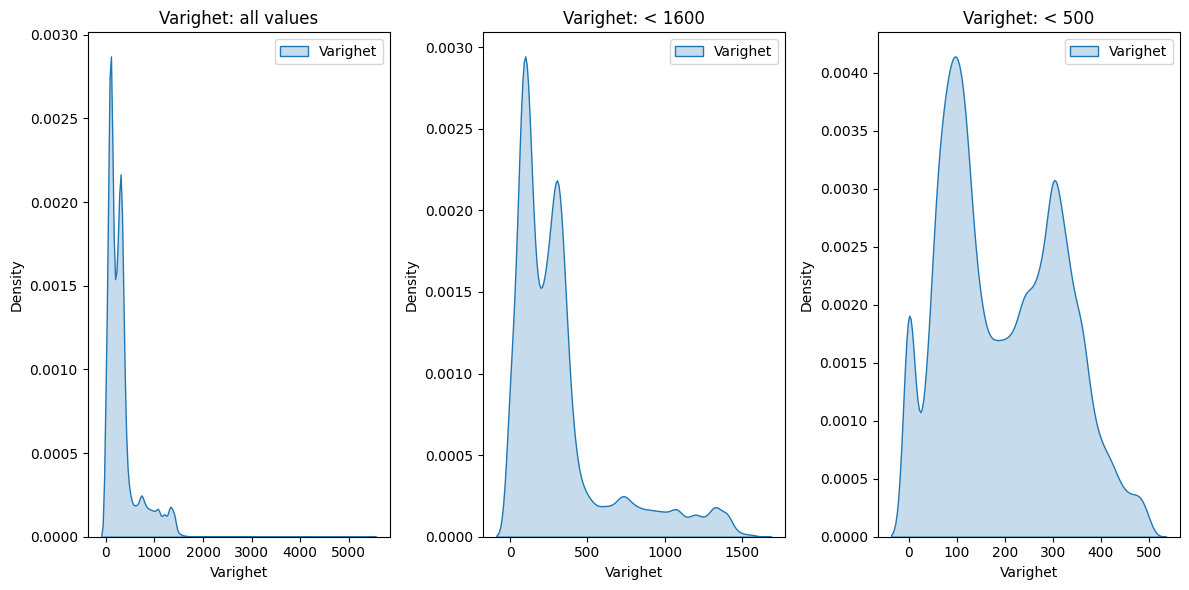

In [127]:
# Visualizing distribution of "Varighet"
df_filtered = df[df['Varighet'] <= 1600]
df_filtered2 = df[df['Varighet'] <= 500]

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.kdeplot(df['Varighet'], label='Varighet', fill=True, ax=axes[0])
axes[0].set_title('Varighet: all values')
axes[0].legend()

sns.kdeplot(df_filtered['Varighet'], label='Varighet', fill=True, ax=axes[1])
axes[1].set_title('Varighet: < 1600')
axes[1].legend()

sns.kdeplot(df_filtered2['Varighet'], label='Varighet', fill=True, ax=axes[2])
axes[2].set_title('Varighet: < 500')
axes[2].legend()

plt.tight_layout()
plt.show()

In [128]:
df = df[df['Varighet'] <= 400]

count    107626.000000
mean      10036.845214
std       11707.966443
min           0.000000
25%        2376.000000
50%        5153.000000
75%       14656.750000
max      632375.000000
Name: Trekkavstand, dtype: float64


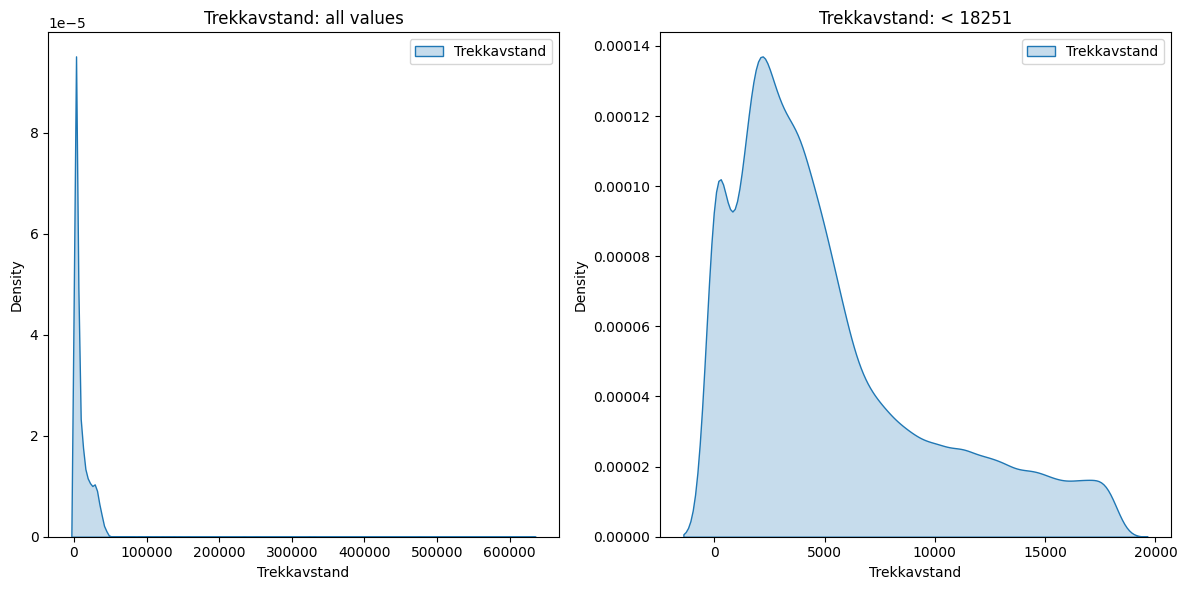

In [129]:
# Showing statistics for "Trekkavstand"
print(df['Trekkavstand'].describe())

## Visualizing distribution of "Trekkavstand"
df_filtered = df[df['Trekkavstand'] <= 18251]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.kdeplot(df['Trekkavstand'], label='Trekkavstand', fill=True, ax=axes[0])
axes[0].set_title('Trekkavstand: all values')
axes[0].legend()

sns.kdeplot(df_filtered['Trekkavstand'], label='Trekkavstand', fill=True, ax=axes[1])
axes[1].set_title('Trekkavstand: < 18251')
axes[1].legend()

plt.tight_layout()
plt.show()

In [130]:
df = df[df['Trekkavstand'] <= 18251]
status_dataframe(df)

The dataset now has 25 columns and 85817 rows


,Melding ID,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Redskap FAO,Art FAO,Rundvekt,Bruttotonnasje,Startposisjon bredde_sin,Startposisjon bredde_cos,Startposisjon lengde_sin,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Startklokke_sin,Startklokke_cos,Stoppklokke_sin,Stoppklokke_cos,Startdag_sin,Startdag_cos,Stoppdag_sin,Stoppdag_cos
1,1497178,-335,295,-334,3970.0,"Bunntrål, otter",Hyse,9594.0,1476.0,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411,-0.16935,0.985556,0.898794,0.438371,-1.721336e-02,0.999852,6.432491e-16,1.0
2,1497178,-335,295,-334,3970.0,"Bunntrål, otter",Torsk,8510.0,1476.0,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411,-0.16935,0.985556,0.898794,0.438371,-1.721336e-02,0.999852,6.432491e-16,1.0
4,1497178,-335,295,-334,3970.0,"Bunntrål, otter",Sei,134.0,1476.0,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411,-0.16935,0.985556,0.898794,0.438371,-1.721336e-02,0.999852,6.432491e-16,1.0
5,1497178,-403,267,-277,11096.0,"Bunntrål, otter",Hyse,9118.0,1476.0,0.502718,-0.864450,0.273422,0.961894,0.502990,-0.864292,0.279796,0.960060,0.99863,0.052336,0.442289,-0.896873,6.432491e-16,1.000000,6.432491e-16,1.0
6,1497178,-403,267,-277,11096.0,"Bunntrål, otter",Torsk,6651.0,1476.0,0.502718,-0.864450,0.273422,0.961894,0.502990,-0.864292,0.279796,0.960060,0.99863,0.052336,0.442289,-0.896873,6.432491e-16,1.000000,6.432491e-16,1.0


<class 'pandas.core.frame.DataFrame'>
Index: 85817 entries, 1 to 305413
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Melding ID                85817 non-null  int64  
 1   Havdybde start            85817 non-null  int64  
 2   Varighet                  85817 non-null  int64  
 3   Havdybde stopp            85817 non-null  int64  
 4   Trekkavstand              85817 non-null  float64
 5   Redskap FAO               85817 non-null  object 
 6   Art FAO                   85817 non-null  object 
 7   Rundvekt                  85817 non-null  float64
 8   Bruttotonnasje            85817 non-null  float64
 9   Startposisjon bredde_sin  85817 non-null  float64
 10  Startposisjon bredde_cos  85817 non-null  float64
 11  Startposisjon lengde_sin  85817 non-null  float64
 12  Startposisjon lengde_cos  85817 non-null  float64
 13  Stopposisjon bredde_sin   85817 non-null  float64
 14  Stopposisj

#### <a id="pivot"></a> Pivoting dataframe

In the dataset each datapoint records the catch of a specific species in a given fishing session. The catch is unique while the fishing session can have its catches recorded over multiple rows. As we want to predicate on the catches of 3 species at the same time we want to put the catch of each species in its own column. To do this we will pivot the table so that each datapoint is one unique fishing session containing information of how much of each species was caught in that one session. The pivot will collapse rows with the same information while using the 3 unique values in 'Art FAO' to create columns of 'Hyse', 'Sei', and 'Torsk'. These columns will be filled with the values from 'Rundvekt'. In the instances of fishing sessions where there were no catches of a certain species the pivot first fills the space with NaN before we change it to 0 to represent that none of that species was caught in that session.

In [131]:
# Pivoting table
df = df.pivot_table(index=['Melding ID','Startposisjon bredde_sin','Startposisjon lengde_sin','Startposisjon bredde_cos', 'Startposisjon lengde_cos',
                           'Stopposisjon bredde_sin', 'Stopposisjon bredde_cos', 'Stopposisjon lengde_sin', 'Stopposisjon lengde_cos', 'Havdybde start', 'Varighet',
                           'Havdybde stopp', 'Trekkavstand', 'Redskap FAO','Bruttotonnasje','Startdag_sin', 'Startdag_cos', 'Stoppdag_sin', 'Stoppdag_cos',
                           'Startklokke_sin', 'Startklokke_cos', 'Stoppklokke_sin', 'Stoppklokke_cos'],
                            columns='Art FAO', values='Rundvekt').reset_index()

# We can finally drop "Melding ID"
df.drop(columns=["Melding ID"], inplace=True)

status_dataframe(df)

The dataset now has 25 columns and 40621 rows


Art FAO,Startposisjon bredde_sin,Startposisjon lengde_sin,Startposisjon bredde_cos,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Redskap FAO,Bruttotonnasje,Startdag_sin,Startdag_cos,Stoppdag_sin,Stoppdag_cos,Startklokke_sin,Startklokke_cos,Stoppklokke_sin,Stoppklokke_cos,Hyse,Sei,Torsk
0,0.502084,0.272028,-0.864819,0.962289,0.502235,-0.864731,0.273859,0.961770,-443,243,-358,3214.0,"Bunntrål, otter",1476.0,6.432491e-16,1.000000,6.432491e-16,1.000000,-0.997564,-0.069756,-0.548293,0.836286,6758.0,NaN,7022.0
1,0.502718,0.273422,-0.864450,0.961894,0.502990,-0.864292,0.279796,0.960060,-403,267,-277,11096.0,"Bunntrål, otter",1476.0,6.432491e-16,1.000000,6.432491e-16,1.000000,0.998630,0.052336,0.442289,-0.896873,9118.0,67.0,6651.0
2,0.503472,0.276443,-0.864011,0.961030,0.502598,-0.864521,0.275117,0.961411,-335,295,-334,3970.0,"Bunntrål, otter",1476.0,-1.721336e-02,0.999852,6.432491e-16,1.000000,-0.169350,0.985556,0.898794,0.438371,9594.0,134.0,8510.0
3,0.503533,0.276577,-0.863976,0.960992,0.502296,-0.864696,0.271306,0.962493,-346,315,-496,10215.0,"Bunntrål, otter",1476.0,6.432491e-16,1.000000,6.432491e-16,1.000000,0.113203,-0.993572,-0.952396,-0.304864,12432.0,68.0,5097.0
4,0.698965,0.224475,-0.715156,0.974480,0.698990,-0.715132,0.223965,0.974597,-71,63,-56,1269.0,Snurrevad,51.0,1.721336e-02,0.999852,1.721336e-02,0.999852,0.496217,-0.868199,0.241922,-0.970296,4.0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40621 entries, 0 to 40620
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Startposisjon bredde_sin  40621 non-null  float64
 1   Startposisjon lengde_sin  40621 non-null  float64
 2   Startposisjon bredde_cos  40621 non-null  float64
 3   Startposisjon lengde_cos  40621 non-null  float64
 4   Stopposisjon bredde_sin   40621 non-null  float64
 5   Stopposisjon bredde_cos   40621 non-null  float64
 6   Stopposisjon lengde_sin   40621 non-null  float64
 7   Stopposisjon lengde_cos   40621 non-null  float64
 8   Havdybde start            40621 non-null  int64  
 9   Varighet                  40621 non-null  int64  
 10  Havdybde stopp            40621 non-null  int64  
 11  Trekkavstand              40621 non-null  float64
 12  Redskap FAO               40621 non-null  object 
 13  Bruttotonnasje            40621 non-null  float64
 14  Startd

In [132]:
# Checking the NaN count
nan_count = df.isna().any(axis=1).sum()
print("Number of rows containing NaN values:", nan_count)
df.isna().sum()

Number of rows containing NaN values: 26180


Art FAO
Startposisjon bredde_sin        0
Startposisjon lengde_sin        0
Startposisjon bredde_cos        0
Startposisjon lengde_cos        0
Stopposisjon bredde_sin         0
Stopposisjon bredde_cos         0
Stopposisjon lengde_sin         0
Stopposisjon lengde_cos         0
Havdybde start                  0
Varighet                        0
Havdybde stopp                  0
Trekkavstand                    0
Redskap FAO                     0
Bruttotonnasje                  0
Startdag_sin                    0
Startdag_cos                    0
Stoppdag_sin                    0
Stoppdag_cos                    0
Startklokke_sin                 0
Startklokke_cos                 0
Stoppklokke_sin                 0
Stoppklokke_cos                 0
Hyse                        15461
Sei                         14680
Torsk                        5908
dtype: int64

In [133]:
# Filling in the NaN with 0 and then re-checking
df.fillna(0, inplace=True)
df.isnull().sum().sum()

0

#### <a id="narrow"> </a> Narrowing our prediction window

We now look at the distribution of our target values. The distribution is across a large range with higher density in the lower numbers. This leads us to the dilemma of degree of model accuracy versus what range is interesting to predict across. Based on this we make the choice of narrowing the distribution range we are predicting by considering higher low frequency numbers as outliers and removing them. Where exactly to draw the line was arrived on by repeatedly testing the models with different ranges, ending with a cutoff point of 14600.

In [134]:
# Calculating the amount of values that will be cut
x = df[df['Hyse'] > 14600].shape[0]
y = df[df['Sei'] > 14600].shape[0]
z = df[df['Torsk'] > 14600].shape[0]
total = x + y + z
print(f"We will cut a total of {total} values. From Hyse: {x}. From Sei: {y}. From Torsk: {z}.")


We will cut a total of 5386 values. From Hyse: 396. From Sei: 2311. From Torsk: 2679.


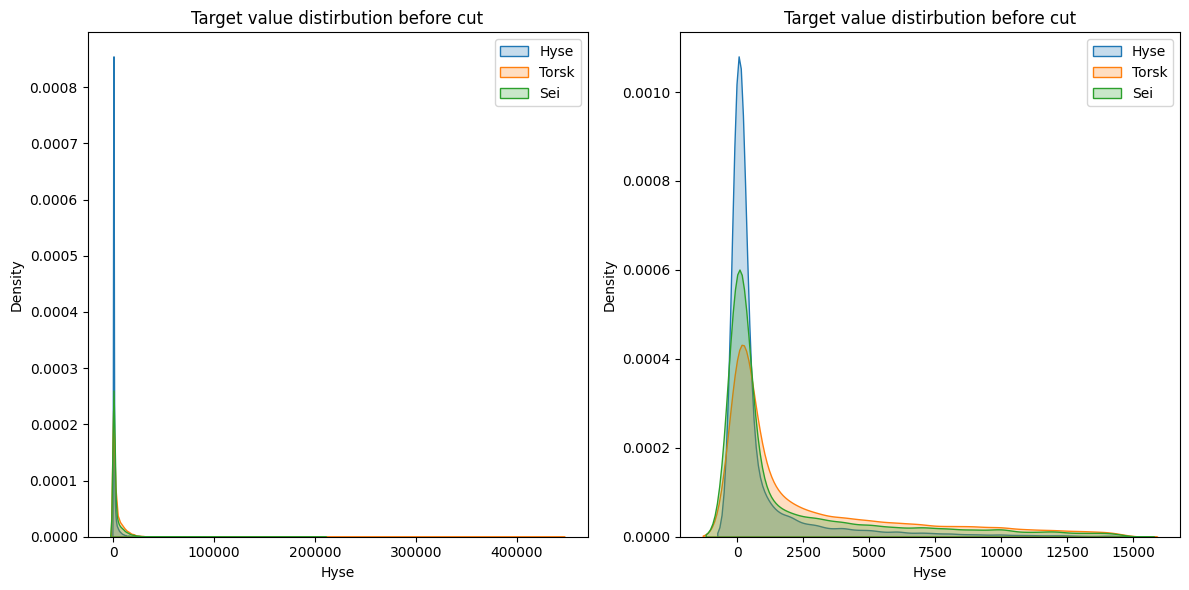

In [135]:
# Showing the value distribution before and after the cutoff
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(df['Hyse'], label='Hyse', fill=True)
sns.kdeplot(df['Torsk'], label='Torsk', fill=True)
sns.kdeplot(df['Sei'], label='Sei', fill=True)
plt.title('Target value distirbution before cut')
plt.legend()

plt.subplot(1, 2, 2)

df = df[df['Hyse'] <= 14600]
df = df[df['Sei']  <= 14600]
df = df[df['Torsk'] <= 14600]

sns.kdeplot(df['Hyse'], label='Hyse', fill=True)
sns.kdeplot(df['Torsk'], label='Torsk', fill=True)
sns.kdeplot(df['Sei'], label='Sei', fill=True)
plt.title('Target value distirbution before cut')
plt.legend()

plt.tight_layout()
plt.show()

### <a id='correlation'></a>Correlation Matrix

As a last exploration step we look at a correlation matrix of all our numerical features. From this we see that the targets 'Hyse', 'Sei', and 'Torsk' have a low correlation score with most of the other features, there are some. This strengthens our suspicion that our chosen problem doesn't have a linear solution and that we need to use models that are good at handling non-linear data relations.

We also see that certain features have a high correlation to each other. If we were to need to make this modeling less computationally expensive we would probably do some further dimensionality reduction, but for now we are satisfied with our selection of features.

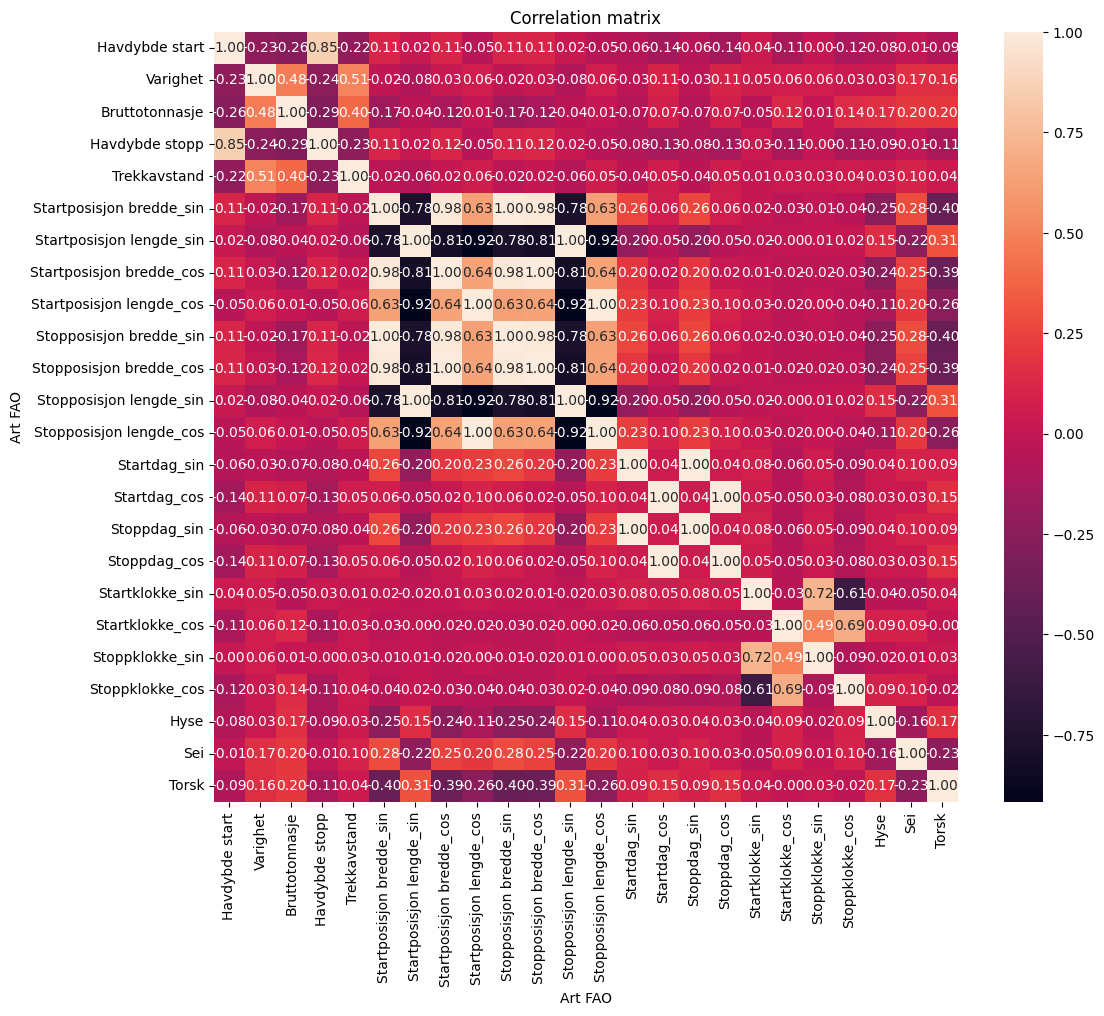

In [136]:
# Setting up a correaltion matrix with our numerical features
df_corr = df[['Havdybde start','Varighet','Bruttotonnasje', 'Havdybde stopp', 'Trekkavstand','Startposisjon bredde_sin','Startposisjon lengde_sin','Startposisjon bredde_cos',
              'Startposisjon lengde_cos', 'Stopposisjon bredde_sin', 'Stopposisjon bredde_cos', 'Stopposisjon lengde_sin', 'Stopposisjon lengde_cos', 'Startdag_sin', 'Startdag_cos',
              'Stoppdag_sin', 'Stoppdag_cos', 'Startklokke_sin', 'Startklokke_cos', 'Stoppklokke_sin', 'Stoppklokke_cos',  'Hyse', 'Sei', 'Torsk']]
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f") 
plt.title('Correlation matrix')
plt.show() 

#### <a id='scaling'></a>Scaling Numerical Features

We choose to use MinMaxScaler, which scales data to a fixed range between 0 and 1, for two reasons. The first one is that we have essentially already done this to a number of features when we circular encoded them so we might as well put the rest of them in the same range. Secondly is that we have already manually managed the outliers, which MinMaxScaler is sensitive to, thus reducing the risk of outlier influence and ensuring that the scaling reflects the true bounds of our feature distribution. Another perk of having managed the outliers is that we don't have to rely on the models to manage them.

This scaling is not important for our two first models, which are decision tree based, but will be for the last one. Even so we are applying the scaling now so that the results can be seen in the context of the same exact features.

In [137]:
# MinMaxScaling numerical features
num_feat = df[['Havdybde start','Varighet', 'Havdybde stopp', 'Trekkavstand', 'Startposisjon bredde_sin','Startposisjon lengde_sin','Startposisjon bredde_cos',
               'Startposisjon lengde_cos','Stopposisjon bredde_sin', 'Stopposisjon bredde_cos', 'Stopposisjon lengde_sin', 'Stopposisjon lengde_cos','Bruttotonnasje',
               'Startdag_sin', 'Startdag_cos', 'Stoppdag_sin', 'Stoppdag_cos', 'Startklokke_sin', 'Startklokke_cos', 'Stoppklokke_sin', 'Stoppklokke_cos']]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(num_feat)
scaled_df = pd.DataFrame(scaled_features, columns=num_feat.columns)
scaled_df.head()

Art FAO,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Startposisjon bredde_sin,Startposisjon lengde_sin,Startposisjon bredde_cos,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Bruttotonnasje,Startdag_sin,Startdag_cos,Stoppdag_sin,Stoppdag_cos,Startklokke_sin,Startklokke_cos,Stoppklokke_sin,Stoppklokke_cos
0,0.818294,0.6075,0.842964,0.176100,0.255355,0.639251,0.088728,0.915707,0.258112,0.089647,0.640360,0.914594,0.330232,0.500000,1.000000,0.500000,1.000000,0.001218,0.465122,0.225853,0.918143
1,0.834775,0.6675,0.878694,0.607967,0.256306,0.640147,0.089145,0.914824,0.259240,0.090143,0.644174,0.910773,0.330232,0.500000,1.000000,0.500000,1.000000,0.999315,0.526168,0.721144,0.051564
2,0.862794,0.7375,0.853551,0.217522,0.257438,0.642088,0.089641,0.912894,0.258654,0.089885,0.641168,0.913791,0.330232,0.491393,0.999926,0.500000,1.000000,0.415325,0.992778,0.949397,0.719186
3,0.858261,0.7875,0.782091,0.559695,0.257528,0.642174,0.089681,0.912807,0.258202,0.089687,0.638720,0.916209,0.330232,0.500000,1.000000,0.500000,1.000000,0.556602,0.003214,0.023802,0.347568
4,0.971570,0.1575,0.976180,0.069530,0.550819,0.608694,0.257924,0.942956,0.552384,0.258619,0.608302,0.943250,0.006809,0.508607,0.999926,0.508607,0.999926,0.748108,0.065901,0.620961,0.014852


#### <a id='onehot'></a> One-hot encoding categorical features

To enable all our models to easily deal with our categorical data, the column "Redskap FAO", it will be one-hot encoded(ref?). This encoding method transforms the feature into a format that avoids any implicit ordinal interpretation by the models, ensuring each category is treated equally and independently. It represents each type of fishing gear as a separate binary feature thus capturing subtle differences in fishing techniques that might influence catch outcomes while also enhancing model interpretability and performance.

In [138]:
# One-hot encoding the categorical feature 
from sklearn.preprocessing import OneHotEncoder
cat_feat = df[['Redskap FAO']]
encoder = OneHotEncoder()
enc_feat= encoder.fit_transform(cat_feat)
enc_df = pd.DataFrame(enc_feat.toarray(), columns=encoder.get_feature_names_out())
enc_df.head()

,Redskap FAO_Andre liner,Redskap FAO_Annen trål (udefinert),Redskap FAO_Boat /vessel seines -Pair seines,Redskap FAO_Bunntrål (uspes),"Redskap FAO_Bunntrål, otter","Redskap FAO_Bunntrål, par","Redskap FAO_Bunntrål, reke",Redskap FAO_Encircling gillnets*,"Redskap FAO_Flytetrål, otter","Redskap FAO_Flytetrål, par","Redskap FAO_Flytetrål, uspesifisert",Redskap FAO_Gillnets and entangling nets (unspec)*,"Redskap FAO_Juksa/pilk, manuell",Redskap FAO_Otter dobbeltrål,"Redskap FAO_Partrål, uspesifisert",Redskap FAO_Settegarn,Redskap FAO_Setteline,Redskap FAO_Snurpenot/ringnot,"Redskap FAO_Snurpenot/ringnot, et fartøy","Redskap FAO_Snurpenot/ringnot, to fartøy",Redskap FAO_Snurrevad,"Redskap FAO_Snurrevad, dansk","Redskap FAO_Snurrevad, skotsk",Redskap FAO_Udefinert garn
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [139]:
# Re-arranging the dataframes for use
features = pd.concat([enc_df, scaled_df], axis=1)
targets = df[['Hyse', 'Sei', 'Torsk']]
status_dataframe(features)
status_dataframe(targets)

The dataset now has 45 columns and 35251 rows


,Redskap FAO_Andre liner,Redskap FAO_Annen trål (udefinert),Redskap FAO_Boat /vessel seines -Pair seines,Redskap FAO_Bunntrål (uspes),"Redskap FAO_Bunntrål, otter","Redskap FAO_Bunntrål, par","Redskap FAO_Bunntrål, reke",Redskap FAO_Encircling gillnets*,"Redskap FAO_Flytetrål, otter","Redskap FAO_Flytetrål, par","Redskap FAO_Flytetrål, uspesifisert",Redskap FAO_Gillnets and entangling nets (unspec)*,"Redskap FAO_Juksa/pilk, manuell",Redskap FAO_Otter dobbeltrål,"Redskap FAO_Partrål, uspesifisert",Redskap FAO_Settegarn,Redskap FAO_Setteline,Redskap FAO_Snurpenot/ringnot,"Redskap FAO_Snurpenot/ringnot, et fartøy","Redskap FAO_Snurpenot/ringnot, to fartøy",Redskap FAO_Snurrevad,"Redskap FAO_Snurrevad, dansk","Redskap FAO_Snurrevad, skotsk",Redskap FAO_Udefinert garn,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Startposisjon bredde_sin,Startposisjon lengde_sin,Startposisjon bredde_cos,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Bruttotonnasje,Startdag_sin,Startdag_cos,Stoppdag_sin,Stoppdag_cos,Startklokke_sin,Startklokke_cos,Stoppklokke_sin,Stoppklokke_cos
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818294,0.6075,0.842964,0.176100,0.255355,0.639251,0.088728,0.915707,0.258112,0.089647,0.640360,0.914594,0.330232,0.500000,1.000000,0.500000,1.000000,0.001218,0.465122,0.225853,0.918143
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.834775,0.6675,0.878694,0.607967,0.256306,0.640147,0.089145,0.914824,0.259240,0.090143,0.644174,0.910773,0.330232,0.500000,1.000000,0.500000,1.000000,0.999315,0.526168,0.721144,0.051564
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.862794,0.7375,0.853551,0.217522,0.257438,0.642088,0.089641,0.912894,0.258654,0.089885,0.641168,0.913791,0.330232,0.491393,0.999926,0.500000,1.000000,0.415325,0.992778,0.949397,0.719186
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.858261,0.7875,0.782091,0.559695,0.257528,0.642174,0.089681,0.912807,0.258202,0.089687,0.638720,0.916209,0.330232,0.500000,1.000000,0.500000,1.000000,0.556602,0.003214,0.023802,0.347568
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.971570,0.1575,0.976180,0.069530,0.550819,0.608694,0.257924,0.942956,0.552384,0.258619,0.608302,0.943250,0.006809,0.508607,0.999926,0.508607,0.999926,0.748108,0.065901,0.620961,0.014852


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35251 entries, 0 to 35250
Data columns (total 45 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Redskap FAO_Andre liner                             35251 non-null  float64
 1   Redskap FAO_Annen trål (udefinert)                  35251 non-null  float64
 2   Redskap FAO_Boat /vessel seines -Pair seines        35251 non-null  float64
 3   Redskap FAO_Bunntrål (uspes)                        35251 non-null  float64
 4   Redskap FAO_Bunntrål, otter                         35251 non-null  float64
 5   Redskap FAO_Bunntrål, par                           35251 non-null  float64
 6   Redskap FAO_Bunntrål, reke                          35251 non-null  float64
 7   Redskap FAO_Encircling gillnets*                    35251 non-null  float64
 8   Redskap FAO_Flytetrål, otter                        35251 non-null  float64


Art FAO,Hyse,Sei,Torsk
0,6758.0,0.0,7022.0
1,9118.0,67.0,6651.0
2,9594.0,134.0,8510.0
3,12432.0,68.0,5097.0
4,4.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 35251 entries, 0 to 40620
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Hyse    35251 non-null  float64
 1   Sei     35251 non-null  float64
 2   Torsk   35251 non-null  float64
dtypes: float64(3)
memory usage: 1.1 MB


## <a id='modeling'></a>Modeling

When choosing our models we were already operating under constraints which ruled out a lot of potential models. We needed regression models that can handle having 3 target features and find non-linear relations. To keep it simple, use the models for what they are best at and avoid overcomplications, we wanted models which could handle these constraints without using any additional techniques. For these reasons we chose RandomForestRegressor(ref?), Xtreme Gradient Boosting(ref?) and MLPRegressor(ref?) as our 3 supervised models, where MLPRegressor is the deep learning one.

In addition we will run a grid search(ref?) on all the models to find optimal parameters. Though due to computational constraints the parameters we search through will in some cases be limited. The grid search has an inbuilt K-Fold cross-validation(ref?) that we will use to get a more reliable estimate of the models performance and robustness against overfitting.

A crucial step before starting to test and train the models is to correctly split the data. The data is split into three parts: training, validation, and test(Müller & Guido, 2016, p. 262). The training data is used to train the model, the validation data is used to tune the hyperparameters of the model and the test data is used to evaluate the model. The test data is not used until the final evaluation of the model. Using this practice we will keep test data hidden until the final 'exam' evaluation, thus avoiding overfitting and ensuring our results are generalisable. 

In [140]:
# Splitting the data
X_train, X_val_test, y_train, y_val_test = train_test_split(features, targets, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.25, random_state=seed)

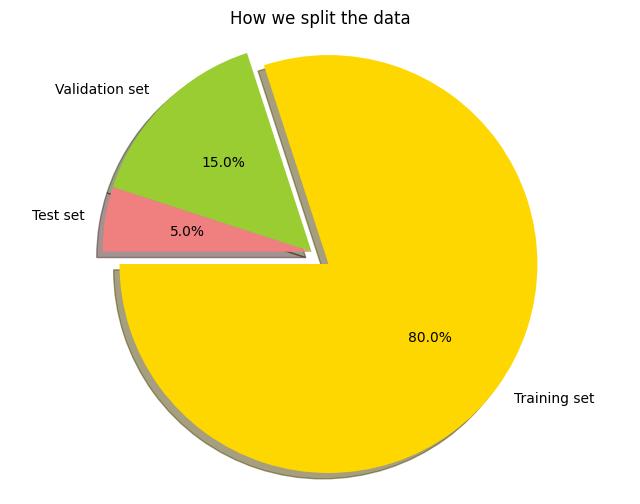

In [141]:
# Visualising how the data is split
total_samples = len(features)
train_size = len(X_train) / total_samples * 100
val_size = len(X_val) / total_samples * 100
test_size = len(X_test) / total_samples * 100

sizes = [train_size, val_size, test_size]
labels = ['Training set', 'Validation set', 'Test set']
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=180)
plt.title('How we split the data')
plt.axis('equal')
plt.show()


#### <a id="model1"> </a> Model 1: Random Forest Regressor

The first model we implement is RandomForestRegressor(ref?). We chose it due to its ability to model non-linear relationships between features and multiple targets. We also want to use its features importance output to do a last round of feature eliminations. For this reason we start the first runs with standard parameters, which sklearn have set up based on empirical evidence(ref?). Through this we find that most of the one-hot encoded features have little to no importance. Once removed it actually seems to improve the score occasionally.

Due to the large size of the dataset we choose to only tune 3 parameters: n_estimators, max_depth and max_features. We know a higher n_estimators will give better results, but it's a curve of diminishing returns over time, so we limit it to 200.

In [142]:
# Running RFR model. 
# N_jobs parameter is set to -1 to let our computers run all processors so runtime is improved.
def rfr_basic(train_x, train_y, val_X, val_y):
    rfr_baseline =  RandomForestRegressor(n_jobs=-1, random_state=seed)
    rfr_baseline.fit(train_x, train_y)
    y_val_pred = rfr_baseline.predict(val_X)
    r2_baseline = r2_score(val_y, y_val_pred)
    print(f"R2 score: {r2_baseline}")
    return rfr_baseline

rfr_model = rfr_basic(X_train, y_train, X_val, y_val)

R2 score: 0.6408067709079245


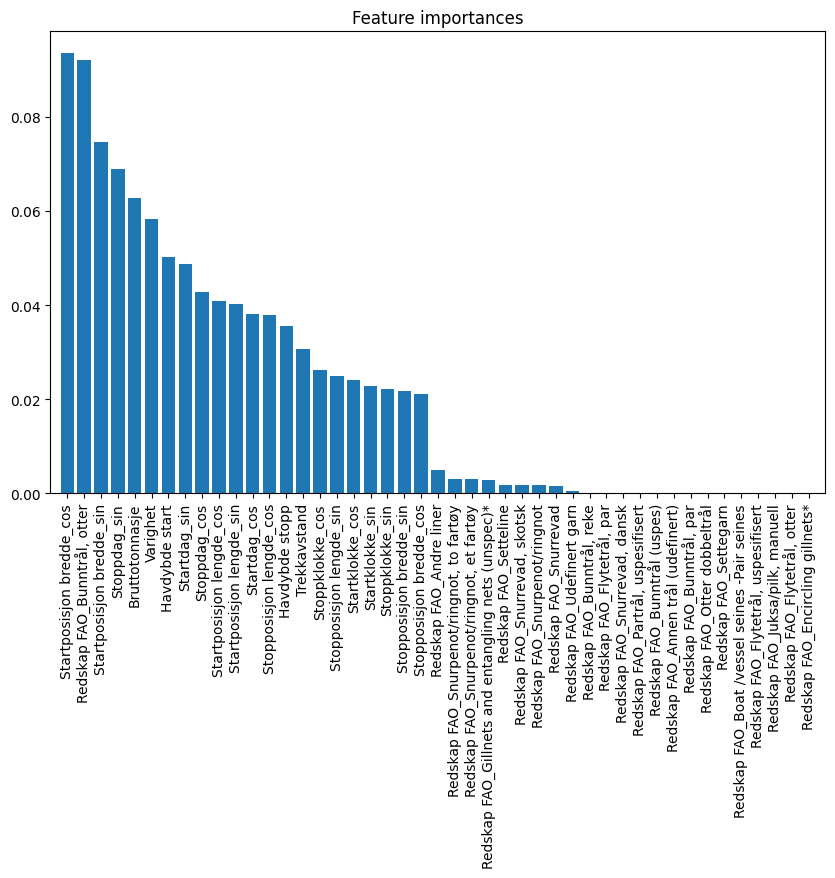

In [143]:
# Looking at feature importance of our model
def rfr_features(model, train_x):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title("Feature importances")
    plt.bar(range(train_x.shape[1]), importances[indices], align="center")
    plt.xticks(range(train_x.shape[1]), train_x.columns[indices], rotation=90)
    plt.xlim([-1, train_x.shape[1]])
    plt.show()

rfr_features(rfr_model, X_train)

R2 score: 0.6413611996243154


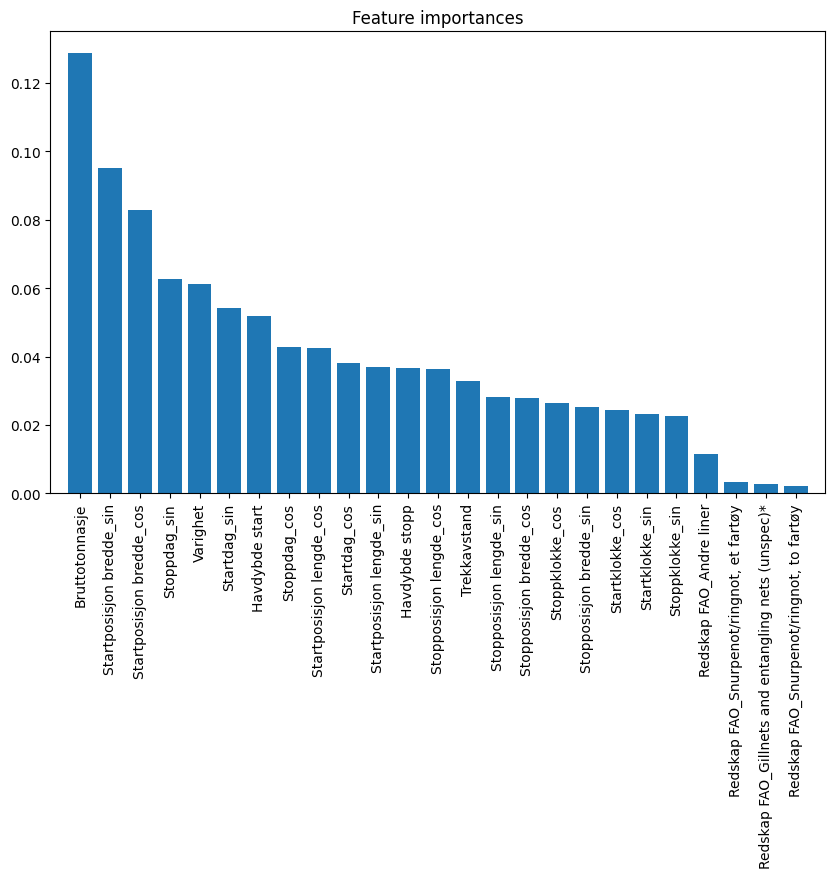

In [144]:
# Testing model accuracy when you remove least important features
features_to_remove = ['Redskap FAO_Annen trål (udefinert)',
       'Redskap FAO_Boat /vessel seines -Pair seines',
       'Redskap FAO_Bunntrål (uspes)', 'Redskap FAO_Bunntrål, otter',
       'Redskap FAO_Bunntrål, par', 'Redskap FAO_Bunntrål, reke',
       'Redskap FAO_Encircling gillnets*', 'Redskap FAO_Flytetrål, otter',
       'Redskap FAO_Flytetrål, par', 'Redskap FAO_Flytetrål, uspesifisert',
       'Redskap FAO_Juksa/pilk, manuell', 'Redskap FAO_Otter dobbeltrål',
       'Redskap FAO_Partrål, uspesifisert', 'Redskap FAO_Settegarn',
       'Redskap FAO_Setteline', 'Redskap FAO_Snurpenot/ringnot', 'Redskap FAO_Snurrevad',
       'Redskap FAO_Snurrevad, dansk', 'Redskap FAO_Snurrevad, skotsk',
       'Redskap FAO_Udefinert garn']

X_train_filtered = X_train.drop(columns=features_to_remove)
X_val_filtered = X_val.drop(columns=features_to_remove)
X_test_filtered = X_test.drop(columns=features_to_remove)
rfr_model = rfr_basic(X_train_filtered, y_train, X_val_filtered, y_val)
rfr_features(rfr_model, X_train_filtered)

In [145]:
# Final dataframe selection and index cleaning
X_train_filtered = X_train_filtered.reset_index(drop=True)
X_val_filtered = X_val_filtered.reset_index(drop=True)
X_test_filtered = X_test_filtered.reset_index(drop=True)
status_dataframe(X_train_filtered)

The dataset now has 25 columns and 28200 rows


,Redskap FAO_Andre liner,Redskap FAO_Gillnets and entangling nets (unspec)*,"Redskap FAO_Snurpenot/ringnot, et fartøy","Redskap FAO_Snurpenot/ringnot, to fartøy",Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Startposisjon bredde_sin,Startposisjon lengde_sin,Startposisjon bredde_cos,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Bruttotonnasje,Startdag_sin,Startdag_cos,Stoppdag_sin,Stoppdag_cos,Startklokke_sin,Startklokke_cos,Stoppklokke_sin,Stoppklokke_cos
0,0.0,0.0,0.0,0.0,0.965801,0.110,0.963829,0.117254,0.843347,0.497520,0.559619,0.997038,0.844277,0.560615,0.497658,0.997005,0.040853,0.002036,0.545117,0.002036,0.545117,0.569587,0.004866,0.473832,0.000685
1,0.0,0.0,0.0,0.0,0.907705,0.990,0.897221,0.057422,0.453044,0.655303,0.191981,0.899135,0.455267,0.192933,0.655148,0.899283,0.415797,0.238290,0.926037,0.245662,0.930479,0.122645,0.828030,0.883022,0.821394
2,0.0,0.0,0.0,0.0,0.896992,0.920,0.868990,0.496576,0.295261,0.699175,0.106810,0.845537,0.296194,0.106927,0.701917,0.841754,0.776668,0.202634,0.901962,0.209597,0.907021,0.007596,0.586824,0.603956,0.989074
3,0.0,0.0,0.0,0.0,0.933251,0.825,0.920600,0.521999,0.730406,0.519315,0.417141,0.991838,0.729551,0.415763,0.517763,0.992282,0.882433,0.895476,0.805940,0.895476,0.805940,0.193891,0.104655,0.068082,0.751887
4,0.0,0.0,0.0,0.0,0.955089,0.455,0.956330,0.085365,0.728508,0.519919,0.415107,0.991657,0.729491,0.415698,0.520199,0.991560,0.775760,0.900684,0.799087,0.900684,0.799087,0.850455,0.856625,1.000000,0.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28200 entries, 0 to 28199
Data columns (total 25 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Redskap FAO_Andre liner                             28200 non-null  float64
 1   Redskap FAO_Gillnets and entangling nets (unspec)*  28200 non-null  float64
 2   Redskap FAO_Snurpenot/ringnot, et fartøy            28200 non-null  float64
 3   Redskap FAO_Snurpenot/ringnot, to fartøy            28200 non-null  float64
 4   Havdybde start                                      28200 non-null  float64
 5   Varighet                                            28200 non-null  float64
 6   Havdybde stopp                                      28200 non-null  float64
 7   Trekkavstand                                        28200 non-null  float64
 8   Startposisjon bredde_sin                            28200 non-null  float64


In [146]:
# Doing a grid search with inbuilt K-Fold cross-validation
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15, 20],
    'max_features': [5, 10, 15, 20]
}

rfr_combined_features = RandomForestRegressor(n_jobs=-1, random_state=seed)
# When cv is set to an integer it will use K-Fold
grid_search = GridSearchCV(estimator=rfr_combined_features, param_grid=param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train_filtered, y_train)

best_rfr = grid_search.best_estimator_
y_val_pred = best_rfr.predict(X_val_filtered)
r2_rfr_combined = r2_score(y_val, y_val_pred)
print(f"Validation R2: {r2_rfr_combined}, Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Validation R2: 0.6555604503345333, Best parameters: {'max_depth': 20, 'max_features': 5, 'n_estimators': 200}


#### <a id="model2"> </a> Model 2: Xtreme Gradient Boosting

For our second method we wanted to use another ensemble method that has similar advantages to random forest: gradient boosting. We ended up using a more advanced and optimized version of it called Xtreme Gradient Boosting (XGBoost)(ref?). XGBoost has many advantages over the sklearn gradient boosting, one of the key ones being that it has a built-in ability to handle multiple target features. To illustrate this we will first test both methods before running gridsearch and K-Fold on XGBoost.

We will run a grid search on 2 parameters: eta(learning rate) and max_depth. We will keep n_estimators on the max we've decided on: 200.


In [147]:
# Running gradient boosting
gbr_combined_features = GradientBoostingRegressor(random_state=seed)
mor = MultiOutputRegressor(gbr_combined_features)
mor.fit(X_train_filtered, y_train)
y_val_pred = mor.predict(X_val_filtered)
r2_gbr = r2_score(y_val, y_val_pred)
print(f"R2 score of sklear gradient boosting: {r2_gbr}")

R2 score of sklear gradient boosting: 0.5086871935607862


In [148]:
# Running XGBoost
xgb_combined_features = XGBRegressor(n_jobs=-1, random_state=seed, multi_strategy ='multi_output_tree')
xgb_combined_features.fit(X_train_filtered, y_train)
y_val_pred = xgb_combined_features.predict(X_val_filtered)
r2_gbr = r2_score(y_val, y_val_pred)
print(f"R2 score of XGBoost: {r2_gbr}")

R2 score of XGBoost: 0.6080347931260522


In [149]:
# Doing a grid search with inbuilt K-Fold cross-validation
param_grid = {
    'max_depth': [3, 5, 7],
    'eta': [0.5,0.4,0.3, 0.1, 0.01,0.001] # 0.3 is standard
}

xgb_combined_features = XGBRegressor(n_jobs=-1, random_state=seed,  n_estimators=200, multi_strategy ='multi_output_tree')
grid_search = GridSearchCV(estimator=xgb_combined_features, param_grid=param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train_filtered, y_train)

best_xgbr = grid_search.best_estimator_
y_val_pred = best_xgbr.predict(X_val_filtered)
r2_xgbr = r2_score(y_val, y_val_pred)
print(f"Validation R2: {r2_xgbr}, Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Validation R2: 0.6162970477422292, Best parameters: {'eta': 0.1, 'max_depth': 7}


#### <a id="model3"> </a> Model 3: MLPRegressor

Our third model, MLPRegressor, is a feedforward neural network that trains using backpropagation and is capable of learning complex relationships between features and multiple targets. Here the most important parameter is the number of layers and the number of hidden units per layer(Müller & Guido, 2016, p. 118). Thus we started with one hidden layer and expanded from there. The other parameters such as activation=relu and learning_rate=adaptive were chosen based on trying to make the model converge faster. 

In [150]:
# Doing a grid search with inbuilt K-Fold cross-validation
param_grid = {
   'hidden_layer_sizes': [(100,), (100, 100), (100,100,100)]
}

mlp_combined_features = MLPRegressor(random_state=seed, activation='relu', solver='adam', batch_size='auto', learning_rate='adaptive', shuffle=True,  early_stopping=True )
grid_search = GridSearchCV(estimator=mlp_combined_features, param_grid=param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train_filtered, y_train)

best_mlp = grid_search.best_estimator_
y_val_pred = best_mlp.predict(X_val_filtered)
r2_mlp = r2_score(y_val, y_val_pred)
print(f"Validation R2: {r2_mlp}, Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\Przybyslaw Paz\Desktop\Code\Studie\INFO284Gruppe\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Przybyslaw Paz\Desktop\Code\Studie\INFO284Gruppe\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Przybyslaw Paz\Desktop\Code\Studie\INFO284Gruppe\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Przybyslaw Paz\Desktop\Code\Studie\INFO284Gruppe\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum i

Validation R2: 0.4816114586421363, Best parameters: {'hidden_layer_sizes': (100, 100, 100)}


c:\Users\Przybyslaw Paz\Desktop\Code\Studie\INFO284Gruppe\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### <a id="final"> </a> Final model test

In [151]:
rfr_tuned =  RandomForestRegressor(max_depth=20 , max_features=5 , n_estimators=200,  n_jobs=-1)
rfr_tuned.fit(X_train_filtered, y_train)
y_test_pred = rfr_tuned.predict(X_test_filtered)
r2_rfr = r2_score(y_test, y_test_pred)
print(f"Random Forest R2: {r2_rfr}")

xgb_tuned = XGBRegressor(n_jobs=-1, eta=0.1, n_estimators=200, max_depth=7, multi_strategy ='multi_output_tree')
xgb_tuned.fit(X_train_filtered, y_train)
y_test_pred = xgb_tuned.predict(X_test_filtered)
r2_rfr = r2_score(y_test, y_test_pred)
print(f"Xtreme Grdient Boost R2: {r2_rfr}")

mlp_tuned = MLPRegressor(hidden_layer_sizes=(100,100,100), activation='relu', solver='adam', batch_size='auto', learning_rate='adaptive', shuffle=True,  early_stopping=True )
mlp_tuned.fit(X_train_filtered, y_train)
y_test_pred = mlp_tuned.predict(X_test_filtered)
r2_rfr = r2_score(y_test, y_test_pred)
print(f"MLP Regressor R2: {r2_rfr}")

Random Forest R2: 0.665571953441466
Xtreme Grdient Boost R2: 0.6340402409487659
MLP Regressor R2: 0.4948801650862491


c:\Users\Przybyslaw Paz\Desktop\Code\Studie\INFO284Gruppe\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### <a id="conclusions"> </a> Concluding comments

In this report we have applied machine learning models to a dataset from Norwegian fisheries, aiming to predict the catches of haddock, cod, and pollock (hyse, torsk, and sei) as continuous values. Our approach involved using three supervised machine learning models tailored to handle the unique constraints of our problem and judged on the basis of their R2 score. There are two specific restrictions worth mentioning in regards to how we judge the results. 1.Two of our models are decision tree based and we have restricted certain values within specific ranges, for example the value range of our targets is < 14600. Which means our predictive accuracy is relevant mostly in those ranges. 2.We have no specific domain knowledge or specific business requirements we are trying to solve. Which means we can speculate what impact our results could have on real-life operations, but it's still abstract until it meets reality.

Nevertheless we seem to have achieved a moderate predictive performance in our models. It suggests that a significant portion of the variability in the catch data is captured by the model, but that there is clear room for improvement. Based on the features used in our models we could to some degree predict when a certain kind of weight class of boat could go out to a specific place to catch a certain amount of the 3 species we have been using as targets. Since we just retained 4 features representing tools our capacity to predict what tools they should use is low, unless you count an advice of "use one of these 4 tools". All of which we suspect is domain knowledge that the fishermen already have.

Let's then instead consider what we would have done if someone actually paid us to create predictive catch models. The first step would be to talk to the fishermen to collect their domain knowledge. Based on this we would select specific features for specific targets, which would in turn determine how we would manipulate the data and which predictive models would be applicable to use.

In general we are positively surprised by the degree of accuracy we were able to get at predicting 3 continuous features. Especially random forest impresses with how easy it is to tune and use, but we suspect that with further tuning the deep learning model has the most future potential of the three. Another thing that stands out is also how superficial our understanding of these tools still is. Contrasted with the amount of potential still hidden in them. If we were to restart this assignment today we are in no doubt that it would have gone smoother, faster and hopefully with better results. 

#### <a id="ref"></a>Referances
ref 1
ref 2